In [1]:
pwd


'/gxfs_work/geomar/smomw662/FESOMparcels_first/notebooks'

In [3]:
import xarray as xr
import numpy as np
import xoak
import matplotlib.pyplot as plt

In [3]:
!ls -1 ../../FESOM_data/channel | head -n 20
#!ls ../../ 

aux3d.out
edge_tri.out
edgenum.out
edges.out
elem2d.out
elvls.out
elvls_raw.out
fesom.mesh.diag.nc
nlvls.out
nod2d.out
u.fesom.1958.nc
u.fesom.1959.nc
u.fesom.1960.nc
u.fesom.1961.nc
u.fesom.1962.nc
u.fesom.1963.nc
u.fesom.1964.nc
u.fesom.1965.nc
u.fesom.1966.nc
u.fesom.1967.nc


In [4]:
ds_mesh = xr.open_dataset("../../FESOM_data/channel/fesom.mesh.diag.nc")
#now we define new coords
ds_mesh = ds_mesh.assign_coords(
    nod2=list(range(1, ds_mesh.sizes["nod2"]+1)), 
    elem=list(range(1,ds_mesh.sizes['elem']+1)),
)

# ds_mesh = ds_mesh.assign_coords(elem=list(range(1,ds_mesh.sizes["elem"]+1)))
# ds_mesh

In [5]:
#By using face_nodes, you can determine the coordinates (e.g., longitude, latitude) 
#of the vertices for each element.

#elem_corner_lons= ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
ds_mesh.face_nodes.values

array([[    1,     2,     3, ..., 10605, 10607, 10607],
       [    2,   223,     4, ...,   219, 10608,   221],
       [  222,   222,   224, ...,   218,   221,   220]], dtype=int32)

In [6]:
# import matplotlib.pyplot as plt
# num_triangles =20
# face_nodes10 = ds_mesh.face_nodes[:,:num_triangles] #grab the first 10 triangles

# #2) Get the coordinates of the triangle vertices
# elem_corner_lons = ds_mesh.lon.sel(nod2=face_nodes10)
# elem_corner_lats = ds_mesh.lat.sel(nod2=face_nodes10)

# #elem_corner_lat10

# #elem_corner_lon10[:,3].values
# plt.figure(figsize=(10,10))

# for ii in range(num_triangles):
#     lons=elem_corner_lons[:,ii].values
#     lats=elem_corner_lats[:,ii].values

#     #close the triangle
#     lons=list(lons) + [lons[0]]
#     lats=list(lats) + [lats[0]]

#     plt.plot(lons,lats,'-o', label=f'Triangle {ii+1}')

#     #Anotate the node numbers
#     for j, (lon,lat) in enumerate(zip(lons[:-1],lats[:-1])):
#         node_number = face_nodes10[j,ii].values
#         plt.text(lon,lat, str(node_number), fontsize=8, color='black')

# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('First 10 triangles and node numbers')
# #plt.legend()
# plt.grid(True)
# plt.show()


In [7]:
elem_corner_lons = ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
elem_corner_lats = ds_mesh.lat.sel(nod2=ds_mesh.face_nodes)
display(elem_corner_lons)
display(elem_corner_lats)

#enhiratages the xarray form

<xarray.DataArray 'lon' (n3: 3, elem: 21120)> Size: 507kB
[63360 values with dtype=float64]
Coordinates:
    nod2     (n3, elem) int64 507kB 1 2 3 4 5 6 7 ... 217 216 219 218 221 220
  * elem     (elem) int64 169kB 1 2 3 4 5 6 ... 21116 21117 21118 21119 21120
Dimensions without coordinates: n3
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

<xarray.DataArray 'lat' (n3: 3, elem: 21120)> Size: 507kB
[63360 values with dtype=float64]
Coordinates:
    nod2     (n3, elem) int64 507kB 1 2 3 4 5 6 7 ... 217 216 219 218 221 220
  * elem     (elem) int64 169kB 1 2 3 4 5 6 ... 21116 21117 21118 21119 21120
Dimensions without coordinates: n3
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [8]:
display(elem_corner_lats.isel(elem=slice(None,3)).compute().data)
display(elem_corner_lons.isel(elem=slice(None,3)).compute().data)

array([[0.    , 0.0814, 0.1628],
       [0.0814, 0.0814, 0.2442],
       [0.    , 0.    , 0.1628]])

array([[0.    , 0.0469, 0.    ],
       [0.0469, 0.1406, 0.0469],
       [0.0938, 0.0938, 0.0938]])

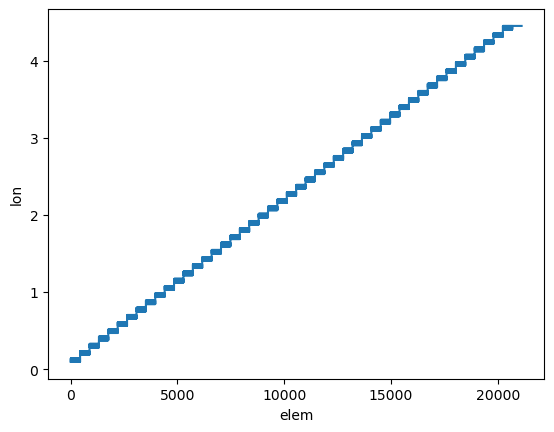

In [9]:
## we are going to find the minimum and maximum differences of the longitudes
#this for checking that there is no overlapping triangles that need to be unglued

elem_corner_lons.max('n3').plot()
#max('n3'): Calculates the maximum longitude among the three nodes for each triangle 
#along the n3 dimension.

In [10]:
max_elem_lon_range = 0.2
tri_overlap=(elem_corner_lons.max('n3') - elem_corner_lons.min('n3')) > max_elem_lon_range
tri_overlap
#4 degrees longitude

<xarray.DataArray 'lon' (elem: 21120)> Size: 21kB
array([False, False, False, ...,  True,  True,  True])
Coordinates:
  * elem     (elem) int64 169kB 1 2 3 4 5 6 ... 21116 21117 21118 21119 21120

In [11]:
near_channel_width =4
channel_width = 4.5
elem_corner_lons_unglued = xr.where(tri_overlap & (elem_corner_lons > near_channel_width), 
                                   elem_corner_lons - channel_width, elem_corner_lons)
#if condition is True it returns elem_corner_lons - 4.5, if it is false it returns elem_corner_lons›

#The condition evaluates overlap status and longitude threshold for each triangular corner. 
#If both are met, it shifts the longitude to fix the overlap issue; otherwise, 
#it leaves the longitude unchanged.

#elem_corner_lons_unglued.plot()


In [12]:
elem_center_lons_unglued = elem_corner_lons_unglued.mean('n3')
elem_center_lats = elem_corner_lats.mean('n3')

elem_center_lons = elem_corner_lons.mean('n3')

#elem_center_lat.plot()

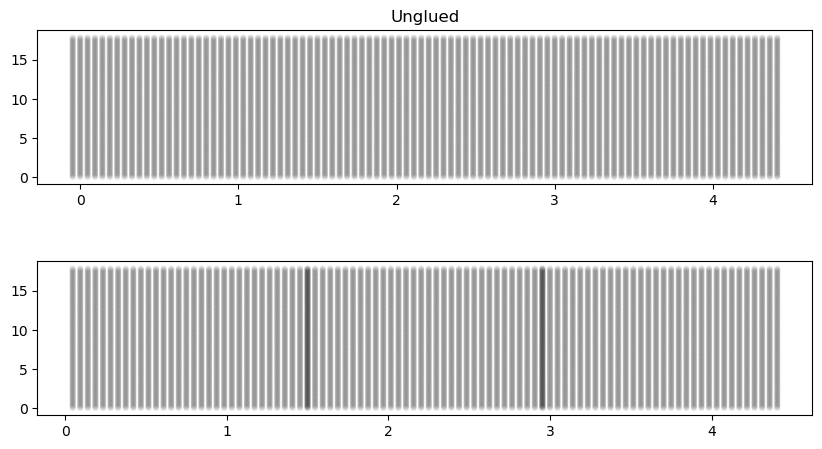

In [13]:
from matplotlib import pyplot as plt

# fig,axs = plt.subplots(2,1, figsize=(10,5))
# fig.subplots_adjust(hspace=.5, wspace=.3)
# axs = axs.ravel()

fig,axs = plt.subplots(2,1, figsize=(10,5))
fig.subplots_adjust(hspace=.5, wspace=.3)
ax = axs.ravel()

axs[0].scatter(elem_center_lons_unglued, elem_center_lats, s=20, alpha=0.05, edgecolor ='none', facecolor='k')
axs[0].set_title('Unglued')

axs[1].scatter(elem_center_lons, elem_center_lats, s=20, alpha=0.05, edgecolor = 'none', facecolor='k')


In [14]:
ds_mesh = ds_mesh.assign_coords(
    elem_center_lons=elem_center_lons_unglued,
    elem_center_lats=elem_center_lats,
)

ds_mesh

<xarray.Dataset> Size: 9MB
Dimensions:            (nz: 41, nz1: 40, elem: 21120, nod2: 10608, n3: 3,
                        n2: 2, edg_n: 31728, N: 6, n4: 4)
Coordinates:
  * nz                 (nz) float64 328B 0.0 9.038 18.98 ... 3.628e+03 4e+03
  * nz1                (nz1) float64 320B 4.519 14.01 ... 3.459e+03 3.814e+03
  * nod2               (nod2) int64 85kB 1 2 3 4 5 ... 10605 10606 10607 10608
  * elem               (elem) int64 169kB 1 2 3 4 5 ... 21117 21118 21119 21120
    elem_center_lons   (elem) float64 169kB 0.0469 0.09377 ... -2.752e-16
    elem_center_lats   (elem) float64 169kB 0.02713 0.05427 ... 17.88 17.85
Dimensions without coordinates: n3, n2, edg_n, N, n4
Data variables: (12/21)
    fesom_mesh         int32 4B ...
    elem_area          (elem) float64 169kB ...
    nlevels_nod2D      (nod2) int32 42kB ...
    nlevels            (elem) int32 84kB ...
    nod_in_elem2D_num  (nod2) int32 42kB ...
    nod_part           (nod2) int32 42kB ...
    ...                 ...
    face_links         (n3, elem) float64 507kB ...
    edge_face_links    (n2, edg_n) float64 508kB ...
    nod_in_elem2D      (N, nod2) int32 255kB ...
    edge_cross_dxdy    (n4, edg_n) float64 1MB ...
    gradient_sca_x     (n3, elem) float64 507kB ...
    gradient_sca_y     (n3, elem) float64 507kB ...
Attributes:
    Conventions:  UGRID-1.0

In [15]:
ds_mesh.xoak.set_index(['elem_center_lats','elem_center_lons'], 'sklearn_geo_balltree')
ds_mesh
#This tells Xoak to build a spatial index for the dataset ds_mesh using the variables 
#elem_center_lats (latitude) and elem_center_lons (longitude).
#It uses a Ball Tree geospatial indexing algorithm (via sklearn).

<xarray.Dataset> Size: 9MB
Dimensions:            (nz: 41, nz1: 40, elem: 21120, nod2: 10608, n3: 3,
                        n2: 2, edg_n: 31728, N: 6, n4: 4)
Coordinates:
  * nz                 (nz) float64 328B 0.0 9.038 18.98 ... 3.628e+03 4e+03
  * nz1                (nz1) float64 320B 4.519 14.01 ... 3.459e+03 3.814e+03
  * nod2               (nod2) int64 85kB 1 2 3 4 5 ... 10605 10606 10607 10608
  * elem               (elem) int64 169kB 1 2 3 4 5 ... 21117 21118 21119 21120
    elem_center_lons   (elem) float64 169kB 0.0469 0.09377 ... -2.752e-16
    elem_center_lats   (elem) float64 169kB 0.02713 0.05427 ... 17.88 17.85
Dimensions without coordinates: n3, n2, edg_n, N, n4
Data variables: (12/21)
    fesom_mesh         int32 4B ...
    elem_area          (elem) float64 169kB ...
    nlevels_nod2D      (nod2) int32 42kB ...
    nlevels            (elem) int32 84kB ...
    nod_in_elem2D_num  (nod2) int32 42kB ...
    nod_part           (nod2) int32 42kB ...
    ...                 ...
    face_links         (n3, elem) float64 507kB ...
    edge_face_links    (n2, edg_n) float64 508kB ...
    nod_in_elem2D      (N, nod2) int32 255kB ...
    edge_cross_dxdy    (n4, edg_n) float64 1MB ...
    gradient_sca_x     (n3, elem) float64 507kB ...
    gradient_sca_y     (n3, elem) float64 507kB ...
Attributes:
    Conventions:  UGRID-1.0

In [16]:
channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0,18)
number_lon = 2*72 
number_lat = 2*292

grid_lon = xr.DataArray(np.linspace(*channel_lon_bds,number_lon), 
                        dims=('grid_lon',))
grid_lat = xr.DataArray(np.linspace(*channel_lat_bds,number_lat),
                        dims=('grid_lat',))
grid_lat

<xarray.DataArray (grid_lat: 584)> Size: 5kB
array([ 0.        ,  0.03087479,  0.06174957,  0.09262436,  0.12349914,
        0.15437393,  0.18524871,  0.2161235 ,  0.24699828,  0.27787307,
        0.30874786,  0.33962264,  0.37049743,  0.40137221,  0.432247  ,
        0.46312178,  0.49399657,  0.52487136,  0.55574614,  0.58662093,
        0.61749571,  0.6483705 ,  0.67924528,  0.71012007,  0.74099485,
        0.77186964,  0.80274443,  0.83361921,  0.864494  ,  0.89536878,
        0.92624357,  0.95711835,  0.98799314,  1.01886792,  1.04974271,
        1.0806175 ,  1.11149228,  1.14236707,  1.17324185,  1.20411664,
        1.23499142,  1.26586621,  1.29674099,  1.32761578,  1.35849057,
        1.38936535,  1.42024014,  1.45111492,  1.48198971,  1.51286449,
        1.54373928,  1.57461407,  1.60548885,  1.63636364,  1.66723842,
        1.69811321,  1.72898799,  1.75986278,  1.79073756,  1.82161235,
        1.85248714,  1.88336192,  1.91423671,  1.94511149,  1.97598628,
        2.00686106,  2.03773585,  2.06861063,  2.09948542,  2.13036021,
        2.16123499,  2.19210978,  2.22298456,  2.25385935,  2.28473413,
        2.31560892,  2.3464837 ,  2.37735849,  2.40823328,  2.43910806,
        2.46998285,  2.50085763,  2.53173242,  2.5626072 ,  2.59348199,
        2.62435678,  2.65523156,  2.68610635,  2.71698113,  2.74785592,
        2.7787307 ,  2.80960549,  2.84048027,  2.87135506,  2.90222985,
        2.93310463,  2.96397942,  2.9948542 ,  3.02572899,  3.05660377,
...
       14.97427101, 15.0051458 , 15.03602058, 15.06689537, 15.09777015,
       15.12864494, 15.15951973, 15.19039451, 15.2212693 , 15.25214408,
       15.28301887, 15.31389365, 15.34476844, 15.37564322, 15.40651801,
       15.4373928 , 15.46826758, 15.49914237, 15.53001715, 15.56089194,
       15.59176672, 15.62264151, 15.6535163 , 15.68439108, 15.71526587,
       15.74614065, 15.77701544, 15.80789022, 15.83876501, 15.86963979,
       15.90051458, 15.93138937, 15.96226415, 15.99313894, 16.02401372,
       16.05488851, 16.08576329, 16.11663808, 16.14751286, 16.17838765,
       16.20926244, 16.24013722, 16.27101201, 16.30188679, 16.33276158,
       16.36363636, 16.39451115, 16.42538593, 16.45626072, 16.48713551,
       16.51801029, 16.54888508, 16.57975986, 16.61063465, 16.64150943,
       16.67238422, 16.70325901, 16.73413379, 16.76500858, 16.79588336,
       16.82675815, 16.85763293, 16.88850772, 16.9193825 , 16.95025729,
       16.98113208, 17.01200686, 17.04288165, 17.07375643, 17.10463122,
       17.135506  , 17.16638079, 17.19725557, 17.22813036, 17.25900515,
       17.28987993, 17.32075472, 17.3516295 , 17.38250429, 17.41337907,
       17.44425386, 17.47512864, 17.50600343, 17.53687822, 17.567753  ,
       17.59862779, 17.62950257, 17.66037736, 17.69125214, 17.72212693,
       17.75300172, 17.7838765 , 17.81475129, 17.84562607, 17.87650086,
       17.90737564, 17.93825043, 17.96912521, 18.        ])
Dimensions without coordinates: grid_lat

In [17]:

#analog to repmat 
target_lon, target_lat = xr.broadcast(grid_lon, grid_lat)
display(target_lon)
display(target_lat)

<xarray.DataArray (grid_lon: 144, grid_lat: 584)> Size: 673kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03146853, 0.03146853, 0.03146853, ..., 0.03146853, 0.03146853,
        0.03146853],
       [0.06293706, 0.06293706, 0.06293706, ..., 0.06293706, 0.06293706,
        0.06293706],
       ...,
       [4.43706294, 4.43706294, 4.43706294, ..., 4.43706294, 4.43706294,
        4.43706294],
       [4.46853147, 4.46853147, 4.46853147, ..., 4.46853147, 4.46853147,
        4.46853147],
       [4.5       , 4.5       , 4.5       , ..., 4.5       , 4.5       ,
        4.5       ]])
Dimensions without coordinates: grid_lon, grid_lat

<xarray.DataArray (grid_lon: 144, grid_lat: 584)> Size: 673kB
array([[ 0.        ,  0.03087479,  0.06174957, ..., 17.93825043,
        17.96912521, 18.        ],
       [ 0.        ,  0.03087479,  0.06174957, ..., 17.93825043,
        17.96912521, 18.        ],
       [ 0.        ,  0.03087479,  0.06174957, ..., 17.93825043,
        17.96912521, 18.        ],
       ...,
       [ 0.        ,  0.03087479,  0.06174957, ..., 17.93825043,
        17.96912521, 18.        ],
       [ 0.        ,  0.03087479,  0.06174957, ..., 17.93825043,
        17.96912521, 18.        ],
       [ 0.        ,  0.03087479,  0.06174957, ..., 17.93825043,
        17.96912521, 18.        ]])
Dimensions without coordinates: grid_lon, grid_lat

In [18]:
# grid_elements = ds_mesh.xoak.sel(
#     elem_center_lats = target_lat,
#     elem_center_lons = target_lon,
# ).elem


grid_elems = ds_mesh.xoak.sel(
    elem_center_lats = target_lat,
    elem_center_lons = target_lon,
).elem

grid_elems = grid_elems.assign_coords(
    target_lat = target_lat,
    target_lon = target_lon,
)

grid_elems = grid_elems.assign_coords(
    grid_lat=grid_lat,
    grid_lon=grid_lon,
)

grid_elems

<xarray.DataArray 'elem' (grid_lon: 144, grid_lat: 584)> Size: 673kB
array([[    1, 20682, 20682, ...,   439,   439,   439],
       [    1,     1, 20682, ...,   439,   439,   439],
       [    1,     1,     2, ...,   439,   439,   439],
       ...,
       [20242, 20242, 20242, ..., 20680, 20679, 20679],
       [20242, 20242, 20242, ..., 20680, 20680, 20679],
       [20242, 20242, 20242, ..., 20680, 20680, 20680]])
Coordinates:
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
  * grid_lat          (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.97 18.0
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5

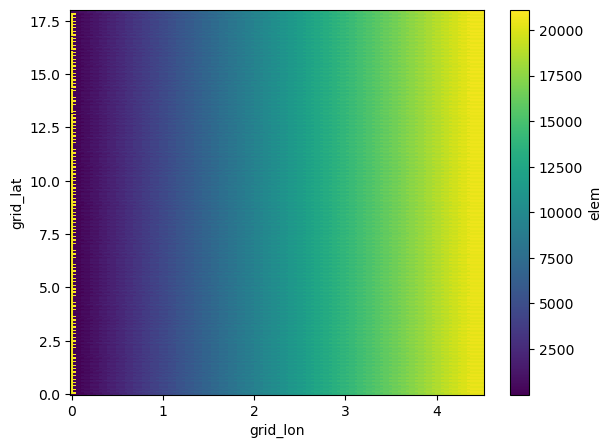

In [19]:
grid_elems.plot.imshow(x='grid_lon', y='grid_lat', size =5)

In [20]:
# ds_u = xr.open_mfdataset('../../FESOM_data/channel/u.fesom.2005.nc',
#                          chunks ={'time':1, 'nz1': 1}).isel(nz1=0,time=slice(0,3))
# # first selecting only the surface nz1=0
# ds_v = xr.open_mfdataset('../../FESOM_data/channel/v.fesom.2005.nc',
#                          chunks = {'time':1, 'nz1':1}).isel(nz1=0,time=slice(0,3))

ds_u = xr.open_mfdataset('../../FESOM_data/channel/u.fesom.2005.nc',
                         chunks ={'time':1, 'nz1': 1}).isel(nz1=0)
# first selecting only the surface nz1=0
ds_v = xr.open_mfdataset('../../FESOM_data/channel/v.fesom.2005.nc',
                         chunks = {'time':1, 'nz1':1}).isel(nz1=0)

print(ds_v)

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 365, elem: 21120)
Coordinates:
    nz1      float64 8B 4.519
  * time     (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-12-31T23:...
Dimensions without coordinates: elem
Data variables:
    v        (time, elem) float32 31MB dask.array<chunksize=(1, 21120), meta=np.ndarray>
Attributes: (12/18)
    Conventions:                         UGRID-1.0
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       ab6d892b
    FESOM_MeshPath:                      /albedo/work/projects/p_clidyn_work/...
    FESOM_mesh_representative_checksum:  
    ...                                  ...
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      0
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    0
    FESOM_autorotate_back_to_geo:        0


/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "nz1" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [21]:
#tic
U_grid = ds_u.u.isel(elem=grid_elems - 1).compute() 
V_grid = ds_v.v.isel(elem=grid_elems - 1).compute()
#toc
## drop the compute 

In [22]:
SPD_grid = (U_grid**2 + V_grid**2) **0.5
SPD_grid

<xarray.DataArray (time: 365, grid_lon: 144, grid_lat: 584)> Size: 123MB
array([[[0.00499139, 0.00936296, 0.00936296, ..., 0.00213555,
         0.00213555, 0.00213555],
        [0.00499139, 0.00499139, 0.00936296, ..., 0.00213555,
         0.00213555, 0.00213555],
        [0.00499139, 0.00499139, 0.00579774, ..., 0.00213555,
         0.00213555, 0.00213555],
        ...,
        [0.01440894, 0.01440894, 0.01440894, ..., 0.00218358,
         0.00200826, 0.00200826],
        [0.01440894, 0.01440894, 0.01440894, ..., 0.00218358,
         0.00218358, 0.00200826],
        [0.01440894, 0.01440894, 0.01440894, ..., 0.00218358,
         0.00218358, 0.00218358]],

       [[0.0016402 , 0.00696312, 0.00696312, ..., 0.00029194,
         0.00029194, 0.00029194],
        [0.0016402 , 0.0016402 , 0.00696312, ..., 0.00029194,
         0.00029194, 0.00029194],
        [0.0016402 , 0.0016402 , 0.0054112 , ..., 0.00029194,
         0.00029194, 0.00029194],
...
        [0.00614518, 0.00614518, 0.00614518, ..., 0.04910338,
         0.04621299, 0.04621299],
        [0.00614518, 0.00614518, 0.00614518, ..., 0.04910338,
         0.04910338, 0.04621299],
        [0.00614518, 0.00614518, 0.00614518, ..., 0.04910338,
         0.04910338, 0.04910338]],

       [[0.01225266, 0.01088561, 0.01088561, ..., 0.05715225,
         0.05715225, 0.05715225],
        [0.01225266, 0.01225266, 0.01088561, ..., 0.05715225,
         0.05715225, 0.05715225],
        [0.01225266, 0.01225266, 0.01691869, ..., 0.05715225,
         0.05715225, 0.05715225],
        ...,
        [0.00652205, 0.00652205, 0.00652205, ..., 0.05066724,
         0.04812414, 0.04812414],
        [0.00652205, 0.00652205, 0.00652205, ..., 0.05066724,
         0.05066724, 0.04812414],
        [0.00652205, 0.00652205, 0.00652205, ..., 0.05066724,
         0.05066724, 0.05066724]]], dtype=float32)
Coordinates:
    nz1               float64 8B 4.519
  * time              (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-...
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
  * grid_lat          (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.97 18.0
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5

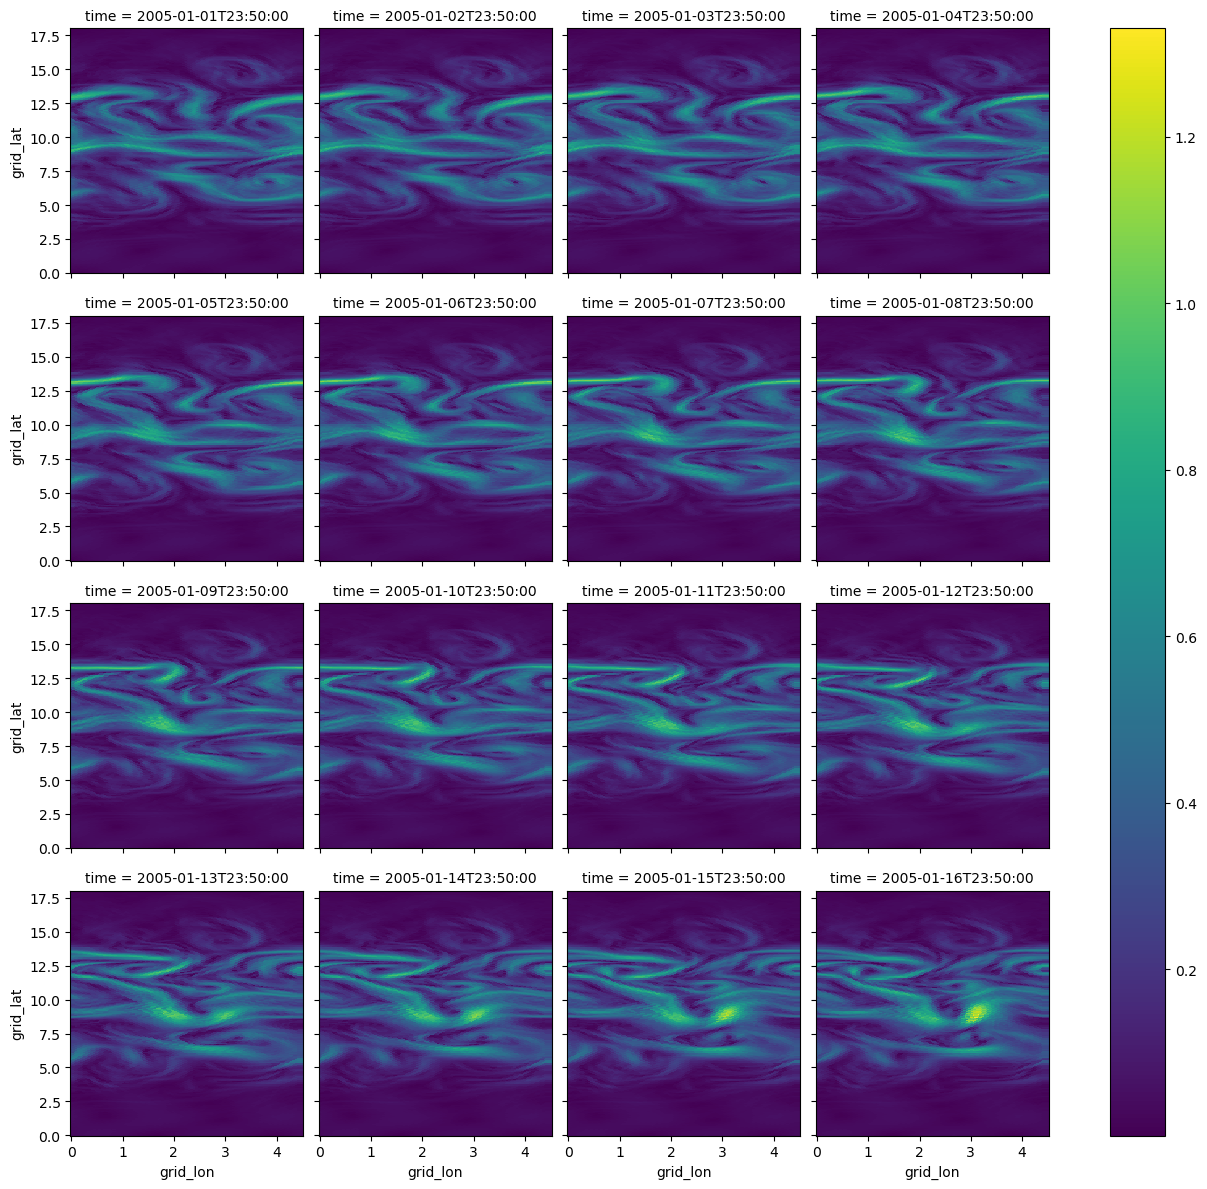

In [23]:
SPD_grid.isel(time=slice(None,16)).plot(x='grid_lon', 
                                        y='grid_lat', col='time',col_wrap=4)

In [24]:
ds_uv_grid= xr.Dataset({
    'U':U_grid,
    "V":V_grid,
})
ds_uv_grid

<xarray.Dataset> Size: 249MB
Dimensions:           (time: 365, grid_lon: 144, grid_lat: 584)
Coordinates:
    nz1               float64 8B 4.519
  * time              (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-...
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
  * grid_lat          (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.97 18.0
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5
Data variables:
    U                 (time, grid_lon, grid_lat) float32 123MB 0.004989 ... 0...
    V                 (time, grid_lon, grid_lat) float32 123MB 0.00016 ... 0....

In [25]:
#ds_uv_grid = ds_uv_grid.isel(time=slice(0,100)).compute()
ds_uv_grid 

<xarray.Dataset> Size: 249MB
Dimensions:           (time: 365, grid_lon: 144, grid_lat: 584)
Coordinates:
    nz1               float64 8B 4.519
  * time              (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-...
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
  * grid_lat          (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.97 18.0
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5
Data variables:
    U                 (time, grid_lon, grid_lat) float32 123MB 0.004989 ... 0...
    V                 (time, grid_lon, grid_lat) float32 123MB 0.00016 ... 0....

## Now Parcels

In [26]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4
from datetime import timedelta
import numpy as np

In [27]:
num_particles = 1000
lon_start = np.random.uniform(2,3,size=(num_particles,)) 
lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))
lon_start

array([2.91417321, 2.24524865, 2.86229473, 2.29695554, 2.43683467,
       2.24059679, 2.90013245, 2.57619692, 2.46736761, 2.82806232,
       2.05604293, 2.00921551, 2.53830634, 2.98403927, 2.80088335,
       2.3386246 , 2.2478444 , 2.23364898, 2.20712732, 2.22025036,
       2.66762194, 2.19134159, 2.8435779 , 2.23793746, 2.46717896,
       2.20612504, 2.35228673, 2.29930132, 2.03016844, 2.41774671,
       2.55401658, 2.099437  , 2.02402127, 2.34243272, 2.5059276 ,
       2.91882813, 2.59225243, 2.97932793, 2.20590833, 2.02162632,
       2.66663025, 2.61835296, 2.14430123, 2.63450763, 2.85539578,
       2.08665056, 2.15807967, 2.19100749, 2.73615502, 2.23030159,
       2.90349423, 2.79945762, 2.59697111, 2.96902924, 2.14436787,
       2.35546176, 2.9740398 , 2.25615085, 2.52582116, 2.29704413,
       2.940207  , 2.39837027, 2.79882306, 2.5588864 , 2.47775074,
       2.82445063, 2.72031629, 2.10563621, 2.84432604, 2.51577444,
       2.35852029, 2.89180073, 2.12656908, 2.8448426 , 2.04419

In [28]:
from parcels import FieldSet

In [29]:
#FieldSet.from_xarray_dataset?
ds_uv_grid

<xarray.Dataset> Size: 249MB
Dimensions:           (time: 365, grid_lon: 144, grid_lat: 584)
Coordinates:
    nz1               float64 8B 4.519
  * time              (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-...
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
  * grid_lat          (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.97 18.0
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5
Data variables:
    U                 (time, grid_lon, grid_lat) float32 123MB 0.004989 ... 0...
    V                 (time, grid_lon, grid_lat) float32 123MB 0.00016 ... 0....

In [30]:
fieldset = FieldSet.from_xarray_dataset(
    ds_uv_grid.transpose('time','grid_lat','grid_lon'),
    variables={'U':"U", "V":"V"},
    dimensions={'lon':'grid_lon',
                'lat':'grid_lat',
                'time':'time'},
    time_periodic=False,
    allow_time_extrapolation=True,
)
#fieldset.U.grid.lon

In [31]:
## we add the halo
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])


fieldset.add_periodic_halo(zonal=True)

In [32]:
def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

In [33]:
pset = ParticleSet.from_list(
    pclass = JITParticle,
    fieldset = fieldset,
    lon=lon_start,
    lat=lat_start,
)

In [34]:
## halo save
fn = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/PeriodicParticle'

output_file = pset.ParticleFile(name=fn, 
                                outputdt=timedelta(hours=1))


In [35]:
pset.execute(
    [AdvectionRK4,periodicBC],
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file= output_file
)

INFO: Output files are stored in /gxfs_work/geomar/smomw662/FESOMparcels_first/data/PeriodicParticle.zarr.
100%|████████████████████████████████████| 864000.0/864000.0 [00:45<00:00, 18944.14it/s]


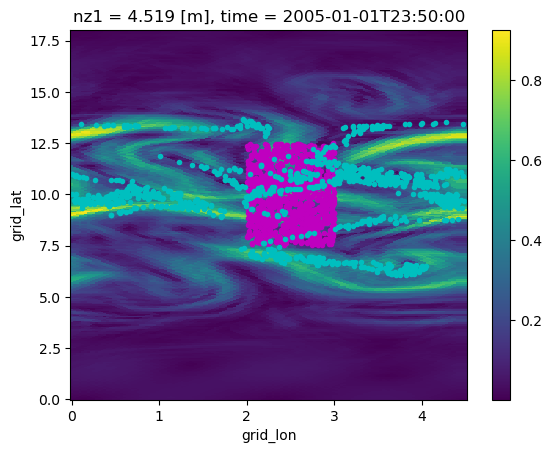

In [36]:
SPD_grid.isel(time=0).plot(x='grid_lon', y='grid_lat')

plt.plot(lon_start,lat_start,'m.')
plt.plot(pset.lon, pset.lat, 'c.')

In [37]:
pwd

'/gxfs_work/geomar/smomw662/FESOMparcels_first/notebooks'

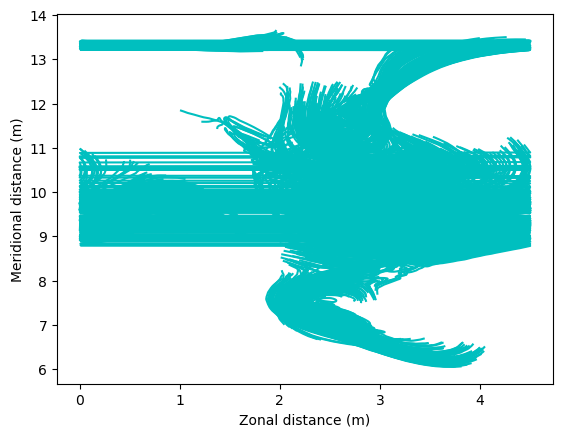

In [4]:
ds_part = xr.open_zarr("../data/PeriodicParticle.zarr")

plt.plot(ds_part.lon.T, ds_part.lat.T, "c-")
plt.xlabel("Zonal distance (m)")
plt.ylabel("Meridional distance (m)")
plt.show()

## Experiment with only one particle

In [ ]:
num_particles = 1
lon_start = np.random.uniform(2,3,size=(num_particles,)) 
lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))

fieldset = FieldSet.from_xarray_dataset(
    ds_uv_grid.transpose('time','grid_lat','grid_lon'),
    variables={'U':"U", "V":"V"},
    dimensions={'lon':'grid_lon',
                'lat':'grid_lat',
                'time':'time'},
    time_periodic=False,
    allow_time_extrapolation=True,
)

## we add the halo
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])


fieldset.add_periodic_halo(zonal=True)

pset = ParticleSet.from_list(
    pclass = JITParticle,
    fieldset = fieldset,
    lon=lon_start,
    lat=lat_start,
)

## halo save
fn = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/PeriodicParticle2'

output_file = pset.ParticleFile(name=fn, 
                                outputdt=timedelta(hours=1))

pset.execute(
    [AdvectionRK4,periodicBC],
    runtime=timedelta(days=360),
    dt=timedelta(minutes=5),
    output_file= output_file
)

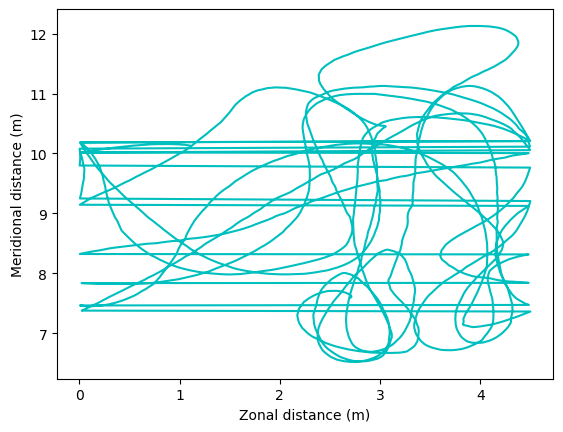

In [5]:
import matplotlib.pyplot as plt

ds_part = xr.open_zarr("../data/PeriodicParticle2.zarr")

plt.plot(ds_part.lon.T, ds_part.lat.T, "c-")
plt.xlabel("Zonal distance (m)")
plt.ylabel("Meridional distance (m)")
plt.show()

 48%|███████████████▍                | 15008700.0/31104000.0 [15:42<16:36, 16146.40it/s]

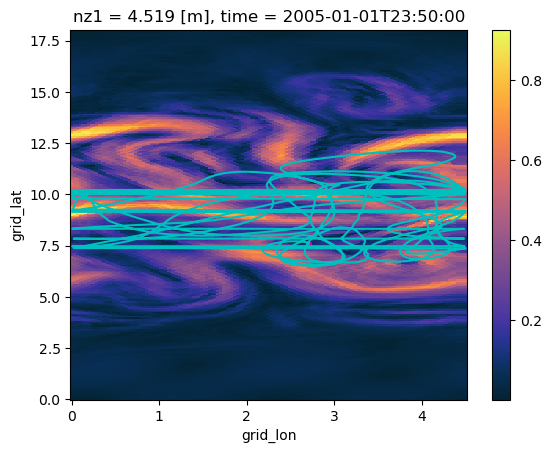

In [41]:
from cmocean import cm

SPD_grid.isel(time=0).plot(x='grid_lon', y='grid_lat',cmap=cm.thermal)

plt.plot(lon_start,lat_start,'m.')
#plt.plot(pset.lon, pset.lat, 'c.')
plt.plot(ds_part.lon.T, ds_part.lat.T, "c-")


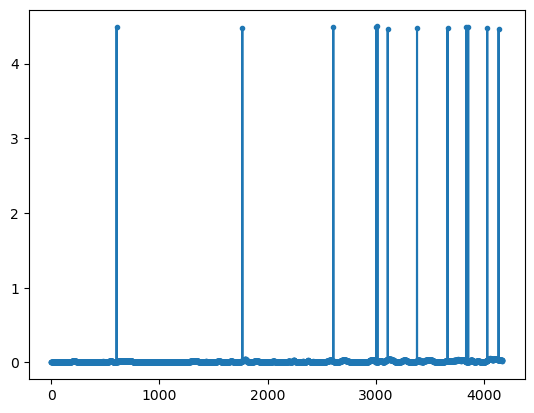

In [42]:
plt.plot(abs(np.diff(ds_part.lon.values)).flatten(),marker='.')


In [43]:
ds_part

<xarray.Dataset> Size: 100kB
Dimensions:     (trajectory: 1, obs: 4170)
Coordinates:
  * obs         (obs) int32 17kB 0 1 2 3 4 5 6 ... 4164 4165 4166 4167 4168 4169
  * trajectory  (trajectory) int64 8B 1000
Data variables:
    lat         (trajectory, obs) float32 17kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 17kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 33kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 17kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4periodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [6]:
#ds_part
#ds_part.where(abs(ds_part.lon.diff('obs'))>4

loni=ds_part.where(abs(ds_part.lon.diff('obs') > 4)).lon.values
lati=ds_part.where(abs(ds_part.lon.diff('obs') > 4)).lat.values
#plt.plot(condition.values.flatten())

In [7]:
ds_part.where(abs(ds_part.lon.diff('obs') > 4)).lon.values

array([[nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
# Replace values where the condition is True
# loni = ds_part.lon * ~condition_aligned.values.flatten()
# lati = ds_part.lat * ~condition_aligned.values.flatten()
# #ds_part['lon'] = ds_part.lon.where(~condition_aligned)
# #ds_part['lat']= ds_part.lat.where(~condition_aligned)
# loni = loni.where(loni != 0, other=np.nan)
# lati = lati.where(lati != 0, other=np.nan)

In [ ]:
# loni.values

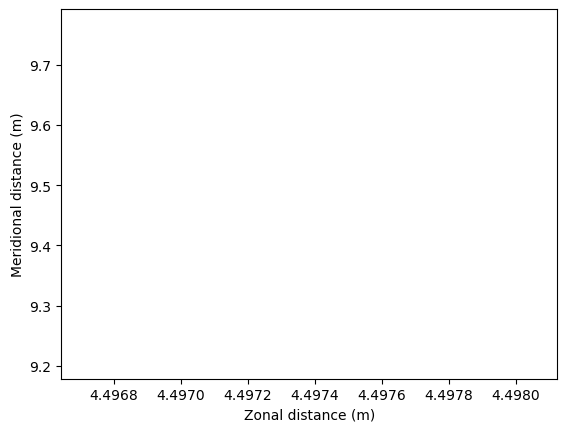

In [8]:
plt.plot(loni.T, lati.T, "c-")
plt.xlabel("Zonal distance (m)")
plt.ylabel("Meridional distance (m)")
plt.show()

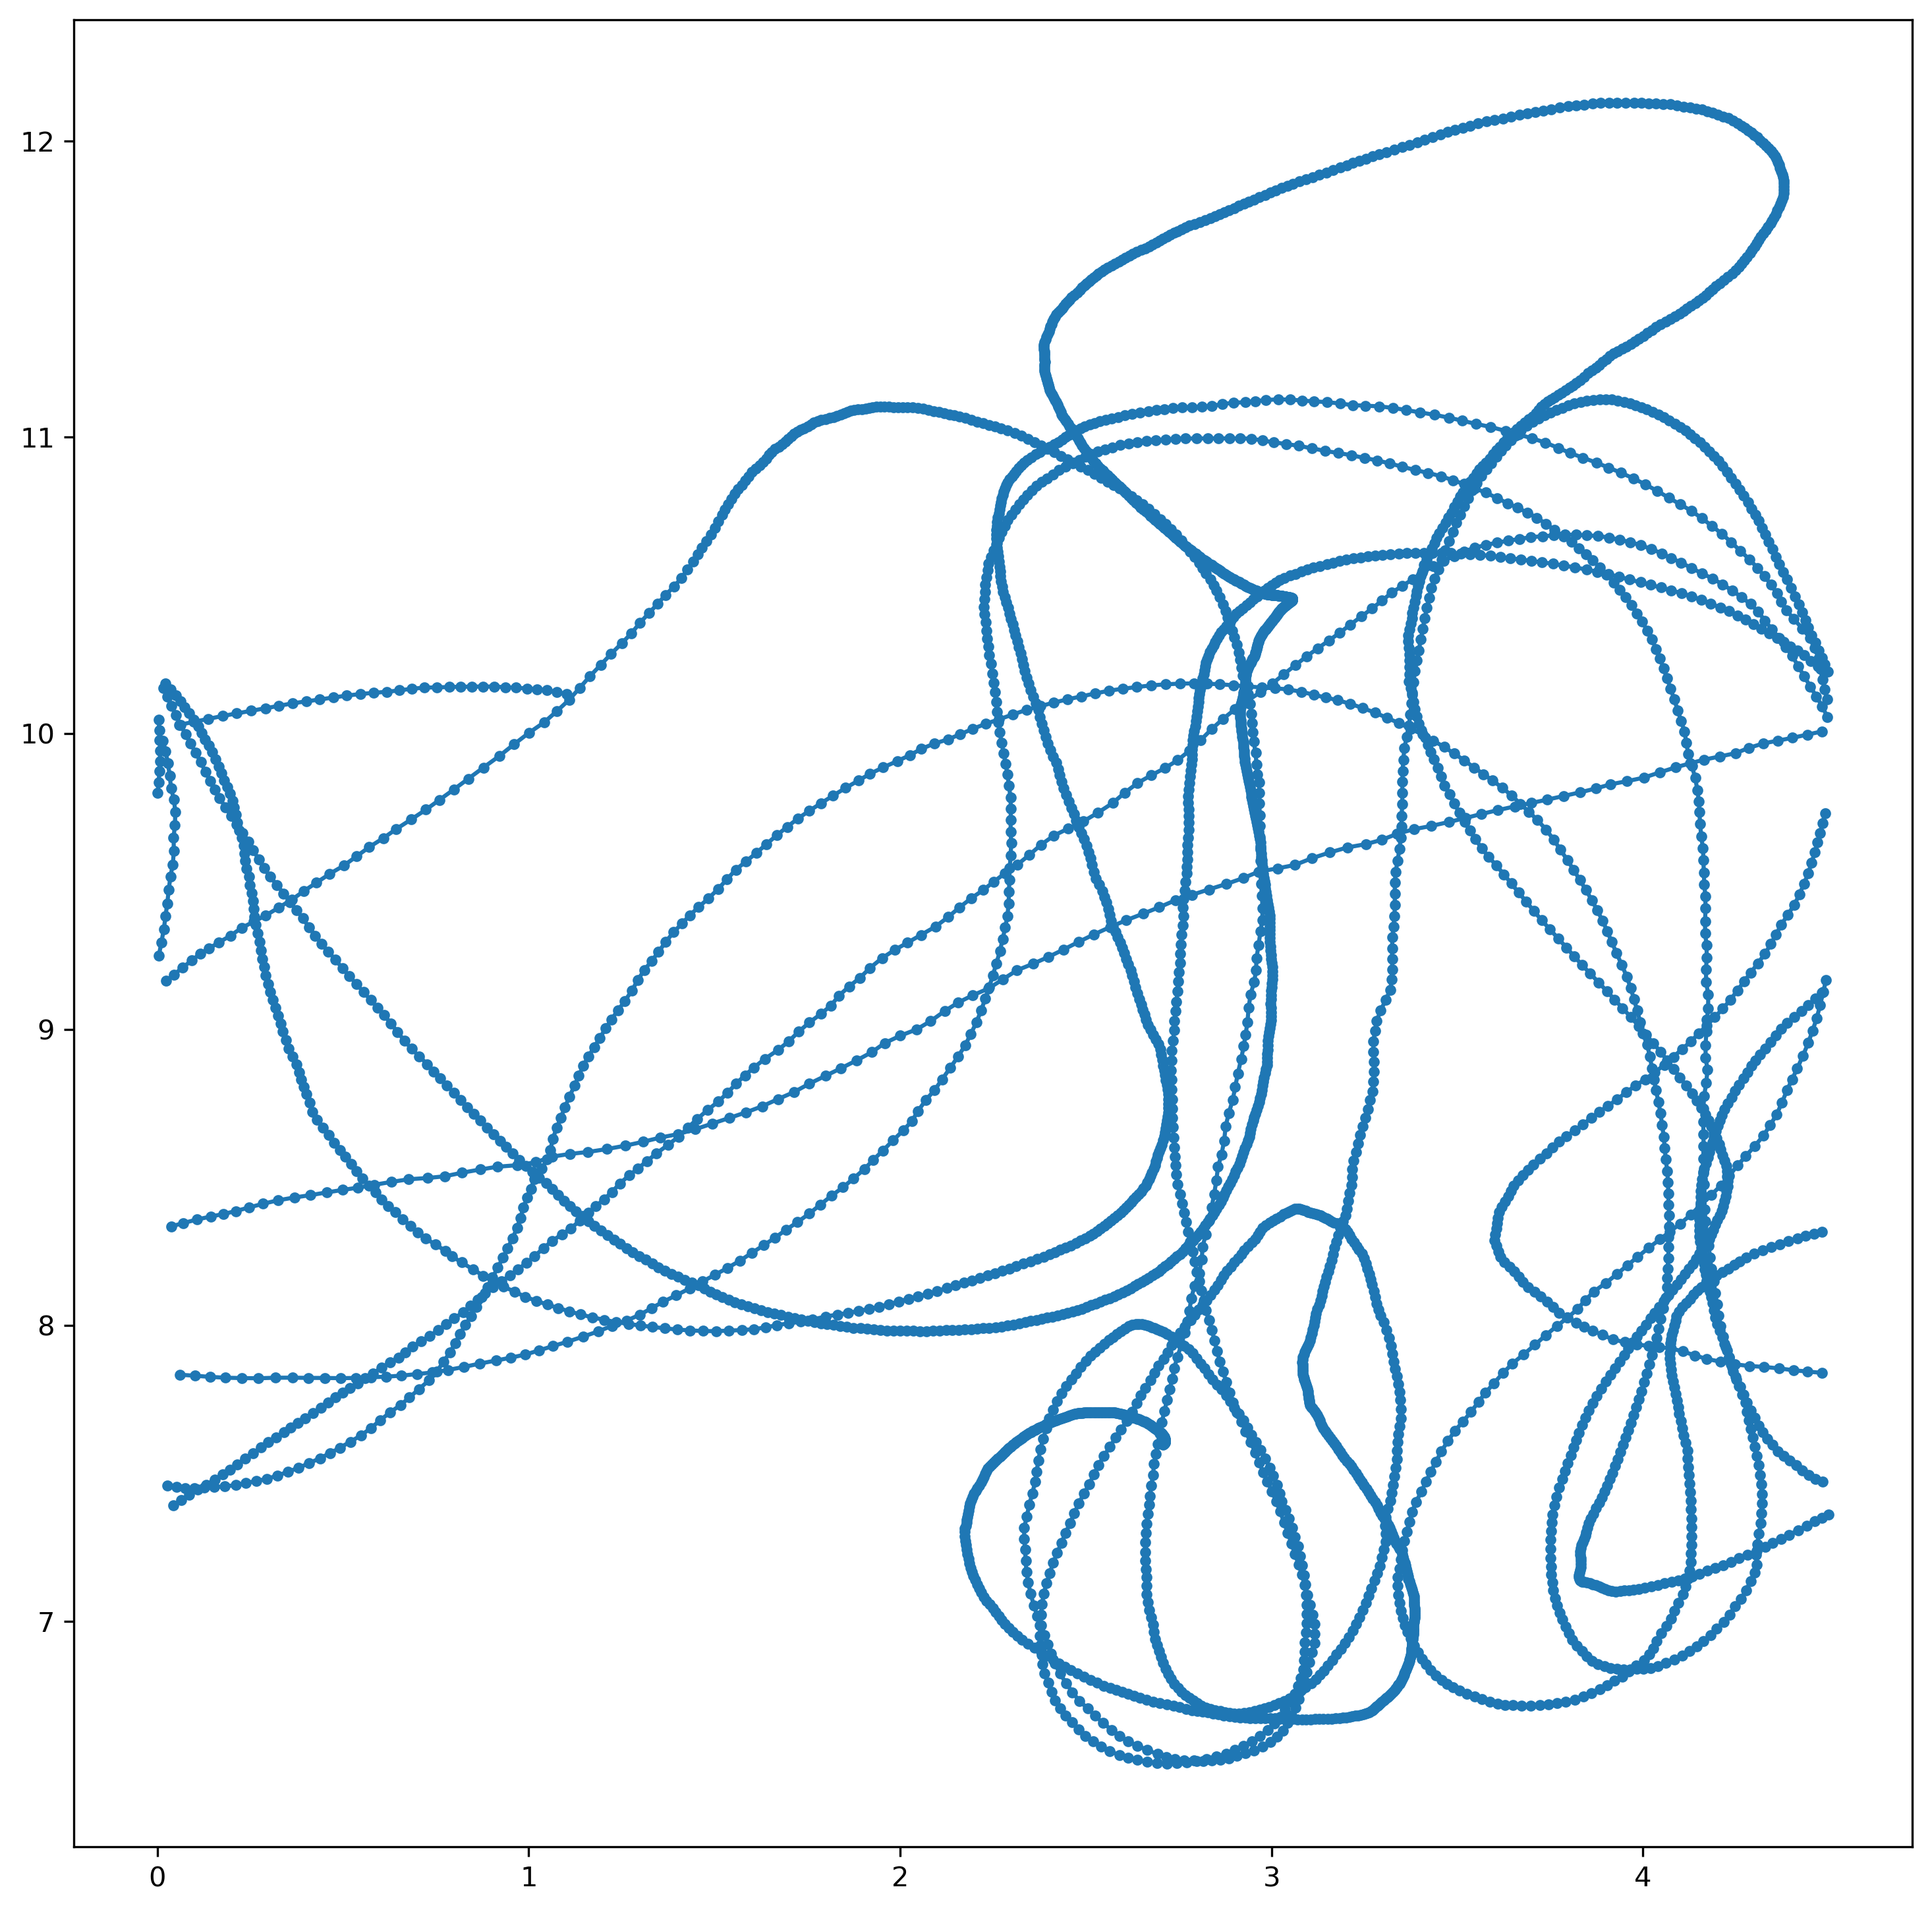

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.set_dpi(300)
ax.plot( 
    ds_part.where(abs(ds_part.lon.diff('obs')) < 4).lon.compute().data.flatten(),
    ds_part.where(abs(ds_part.lon.diff('obs')) < 4).lat.compute().data.flatten(),
    '.-',
)

In [ ]:
## look at the unrolling and transparency